<font size=6><b>Online Retail II UCI
* ref:https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

* 구매 고객 Clustering, 고객 성향 확인
    * RFM : 가치있는 고객을 추출해 내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법
        * R(Recency): 거래의 최근성
        * F(Frequency): 거래빈도
        * M(Monetary): 거래규모

* InvoiceNo: 송장 번호입니다. 명사 같은. 각 트랜잭션에 고유하게 할당된 6자리 정수입니다. 이 코드가 문자 'c'로 시작하면 취소를 나타냅니다.
* StockCode: 제품(항목) 코드입니다. 명사 같은. 각 개별 제품에 고유하게 할당된 5자리 정수 번호입니다.
* Description: 제품(항목) 이름입니다. 명사 같은.
* Quantity: 거래당 각 제품(항목)의 수량입니다. 숫자.
* InvoiceDate: 송장 날짜 및 시간. 숫자. 트랜잭션이 생성된 날짜와 시간입니다.
* Price: 단가. 숫자. 스털링 단위의 제품 가격(£).
* Customer ID: 고객 번호입니다. 명사 같은. 각 고객에게 고유하게 할당된 5자리 정수 번호입니다.
* Country: 국가 이름입니다. 명사 같은. 고객이 거주하는 국가의 이름입니다.

In [83]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [84]:
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score

# Data Load

In [85]:
df = pd.read_csv('./online_retail_II.csv', parse_dates=['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [87]:
df = df.dropna(axis=0)

In [88]:
df.shape

(824364, 8)

# Feature Engineering

## Invoice
* InvoiceNo : 각 트랙잭션에 고유하게 부여되는 ID 값으로, 고객을 그룹화하는데는 의미가 없다고 판단됨. (drop)
* C를 포함하는 경우, 취소건.
    * 취소건의 건유 Quantity와 Price가 정상건 대비 다르게 되어 있음.
    * 삭제 후, 정상거래 고객에 대해 분석함.

In [89]:
df['Invoice'].nunique()

44876

In [90]:
df[df['Invoice'].str.contains('C')].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


In [91]:
# cancle_idx = df[df['Invoice'].str.contains('C')].index.values
# df['cancle'] = 0
# df.loc[cancle_idx, 'cancle'] = 1
# df['cancle'].value_counts()

In [92]:
del_idx = df[df['Invoice'].str.contains('C')].index.values
df = df.drop(del_idx, axis=0)

## StockCode, Description

In [93]:
df[['StockCode','Description']].head()

,StockCode,Description
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,79323P,PINK CHERRY LIGHTS
2,79323W,WHITE CHERRY LIGHTS
3,22041,"RECORD FRAME 7"" SINGLE SIZE"
4,21232,STRAWBERRY CERAMIC TRINKET BOX


In [94]:
df['StockCode'].nunique()

4631

In [95]:
df['Description'].nunique()

5283

In [96]:
# 유사 상품들과 연결?? 일단 Lights는 7000, 8000, 2000, 3000번대에 있음.
# 추가로 StockCode에 상품의 색상등을 나타내는 문자가 포함되어 있음.  --> 해당 문자 분리 필요.
df[df['Description'].str.contains('LIGHTS')]['StockCode'].value_counts()[:5]

79321     960
85048     458
72351B    442
22941     437
22179     416
Name: StockCode, dtype: int64

In [97]:
# df['Stock_color'] = df['StockCode'].str[5:]
df['StockCode'] = df['StockCode'].str[:5]

## InvoiceDate

In [98]:
df['Invoice_y'] = df['InvoiceDate'].dt.year
df['Invoice_m'] = df['InvoiceDate'].dt.month
df['Invoice_h'] = df['InvoiceDate'].dt.hour

## Country      
* 대부분 데이터가 United Kingdom.
* 분석의 대상을 영국으로 제한하고 그외 데이터들 삭제

In [99]:
df['Country'].value_counts()

United Kingdom          725296
Germany                  16703
EIRE                     15745
France                   13813
Netherlands               5093
Spain                     3720
Belgium                   3069
Switzerland               3012
Portugal                  2446
Australia                 1815
Channel Islands           1569
Italy                     1468
Norway                    1437
Sweden                    1319
Cyprus                    1155
Finland                   1032
Austria                    922
Denmark                    798
Greece                     657
Unspecified                521
Poland                     512
Japan                      485
USA                        409
United Arab Emirates       383
Singapore                  339
Israel                     322
Malta                      282
Iceland                    253
Canada                     228
Lithuania                  189
RSA                        123
Brazil                      94
Thailand

In [100]:
del_idx = df[df['Country'] != 'United Kingdom'].index.values
df = df.drop(del_idx, axis=0)

## Cutomer ID Group
* RFM : 가치있는 고객을 추출해 내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법
    * R(Recency): 거래의 최근성
    * F(Frequency): 거래빈도
    * M(Monetary): 거래규모

In [101]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Invoice_y,Invoice_m,Invoice_h
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,7
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,7
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,7


In [102]:
# M(Monetary): 거래규모
df['TotalPrice'] = df['Price']*df['Quantity']
gdf = df.groupby('Customer ID')[['TotalPrice']].mean().sort_index()
gdf['maxPrice'] = df.groupby('Customer ID')[['Price']].max().sort_index()
gdf['minPrice'] = df.groupby('Customer ID')[['Price']].min().sort_index()
gdf['Quantity'] = df.groupby('Customer ID')['Quantity'].mean().sort_index()
gdf['maxQuantity'] = df.groupby('Customer ID')['Quantity'].max().sort_index()
gdf['minQuantity'] = df.groupby('Customer ID')['Quantity'].min().sort_index()

# F(Frequency): 거래빈도
gdf['OrderCount']  = df.groupby('Customer ID')['Invoice'].count().sort_index()

# # R(Recency): 거래의 최근성
gdf['Invoicedata_Recent'] = df.groupby('Customer ID')['InvoiceDate'].max().sort_index()
gdf['Invoicedata_first'] = df.groupby('Customer ID')['InvoiceDate'].min().sort_index()

# gdf['Invoicedata_Recent_y'] = gdf['Invoicedata_Recent'].dt.year
# gdf['Invoicedata_Recent_m'] = gdf['Invoicedata_Recent'].dt.month
# gdf['Invoicedata_Recent_d'] = gdf['Invoicedata_Recent'].dt.day

# gdf['Invoicedata_first_y'] = gdf['Invoicedata_first'].dt.year
# gdf['Invoicedata_first_m'] = gdf['Invoicedata_first'].dt.month
# gdf['Invoicedata_first_d'] = gdf['Invoicedata_first'].dt.day

gdf['Invoicedata_defore'] = df['InvoiceDate'].max() - gdf['Invoicedata_Recent']
gdf['Invoicedata_defore'] = gdf['Invoicedata_defore']/ np.timedelta64(1, "D")

gdf['Invoicedata_duration'] = gdf['Invoicedata_Recent']-gdf['Invoicedata_first'].sort_index()
gdf['Invoicedata_duration'] = gdf['Invoicedata_duration']/ np.timedelta64(1, "D")
gdf.head()

,TotalPrice,maxPrice,minPrice,Quantity,maxQuantity,minQuantity,OrderCount,Invoicedata_Recent,Invoicedata_first,Invoicedata_defore,Invoicedata_duration
Customer ID,,,,,,,,,,,
12346.0,2281.072353,7.49,1.00,2184.852941,74215,1,34,2011-01-18 10:01:00,2009-12-14 08:34:00,325.116667,400.060417
12608.0,25.986875,2.95,0.65,20.187500,96,1,16,2010-10-31 10:49:00,2010-10-31 10:49:00,404.083333,0.000000
12745.0,32.902273,9.95,0.42,21.227273,72,2,22,2010-08-10 10:14:00,2010-05-14 16:50:00,486.107639,87.725000
12746.0,14.973529,7.95,1.25,5.705882,12,2,17,2010-06-17 10:41:00,2010-06-17 10:41:00,540.088889,0.000000
12747.0,36.095486,19.95,0.65,10.731518,48,1,257,2011-12-07 14:34:00,2009-12-07 13:23:00,1.927083,730.049306


In [103]:
gdf['Invoicedata_Recent'] = df.groupby('Customer ID')['InvoiceDate'].max().sort_index()
gdf['Invoicedata_first'] = df.groupby('Customer ID')['InvoiceDate'].min().sort_index()

gdf = gdf.drop(['Invoicedata_Recent','Invoicedata_first'], axis=1)

In [104]:
gdf.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5353 entries, 12346.0 to 18287.0
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TotalPrice            5353 non-null   float64
 1   maxPrice              5353 non-null   float64
 2   minPrice              5353 non-null   float64
 3   Quantity              5353 non-null   float64
 4   maxQuantity           5353 non-null   int64  
 5   minQuantity           5353 non-null   int64  
 6   OrderCount            5353 non-null   int64  
 7   Invoicedata_defore    5353 non-null   float64
 8   Invoicedata_duration  5353 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 418.2 KB


# Cluster

## KMeans

In [105]:
gdf = gdf.reset_index()
gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5353 entries, 0 to 5352
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer ID           5353 non-null   float64
 1   TotalPrice            5353 non-null   float64
 2   maxPrice              5353 non-null   float64
 3   minPrice              5353 non-null   float64
 4   Quantity              5353 non-null   float64
 5   maxQuantity           5353 non-null   int64  
 6   minQuantity           5353 non-null   int64  
 7   OrderCount            5353 non-null   int64  
 8   Invoicedata_defore    5353 non-null   float64
 9   Invoicedata_duration  5353 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 418.3 KB


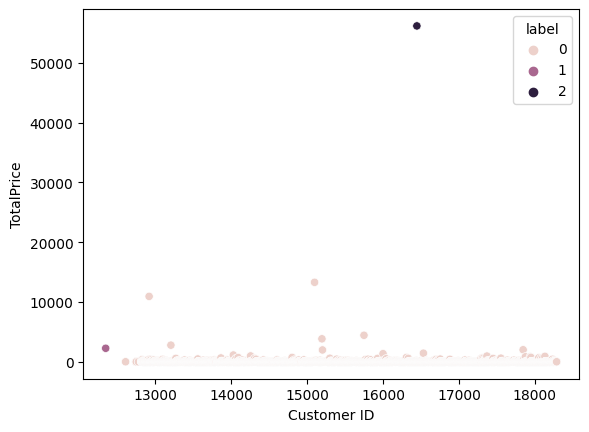

In [107]:
X = gdf.drop('Customer ID', axis=1)

kmeans = KMeans(n_clusters=3, random_state=11)
kmeans.fit(X)   # ---- Predict 할때, y data가 없다.
gdf['label'] = kmeans.labels_

sns.scatterplot(gdf, x='Customer ID', y='TotalPrice', hue='label')
plt.show()

In [108]:
inert = kmeans.inertia_
sil_score = silhouette_score(X, kmeans.labels_)
inert, sil_score

(3100795431.2942615, 0.9915683589199534)

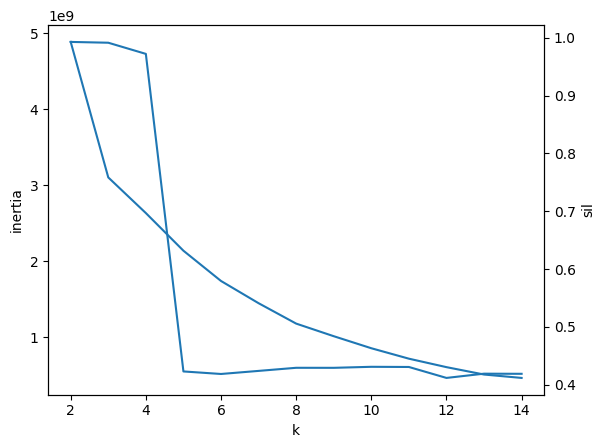

In [109]:
# k 찾기
X = gdf.drop(['Customer ID', 'label'], axis=1)
scor_list = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=11)
    kmeans.fit(X)   # ---- Predict 할때, y data가 없다.
    inert = kmeans.inertia_
    sil_score = silhouette_score(X, kmeans.labels_)
    scor_list.append([k, inert, sil_score])

tempdf = pd.DataFrame(scor_list, columns=['k', 'inertia', 'sil'])

# plt.figure(figsize=(5,3))
fig, ax1 = plt.subplots()
sns.lineplot(tempdf, x='k', y='inertia', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(tempdf, x='k', y='sil', ax=ax2)
plt.show()

224.5729313952616 0.5478493212016395
[0.78847991 0.19987855]


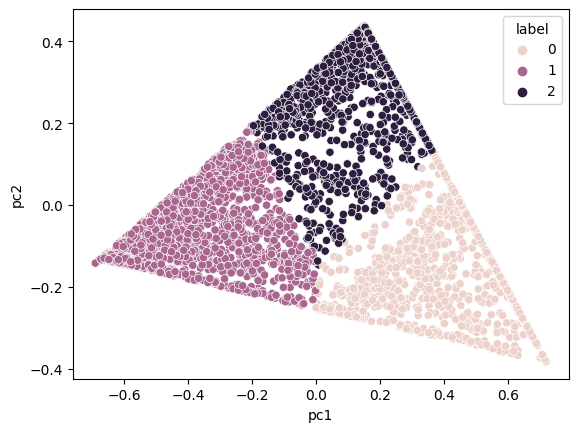

In [149]:
X = gdf.drop(['Customer ID', 'label'], axis=1)

ss = MinMaxScaler()
X2 = ss.fit_transform(X)

# X2 = np.log1p(X)

# kmeans = KMeans(n_clusters=4, random_state=11)
kmeans = KMeans(n_clusters=3, random_state=11)
kmeans.fit(X2)   # ---- Predict 할때, y data가 없다.
gdf['label'] = kmeans.labels_

inert = kmeans.inertia_
sil_score = silhouette_score(X2, kmeans.labels_)
print(inert, sil_score)

pca = PCA(n_components= 2)

X2 = pca.fit_transform(X2)
print(pca.explained_variance_ratio_)

tempdf = pd.DataFrame(X2, columns=['pc1','pc2'])
tempdf['label'] = kmeans.labels_

sns.scatterplot(tempdf, x='pc1', y='pc2', hue='label')
plt.show()

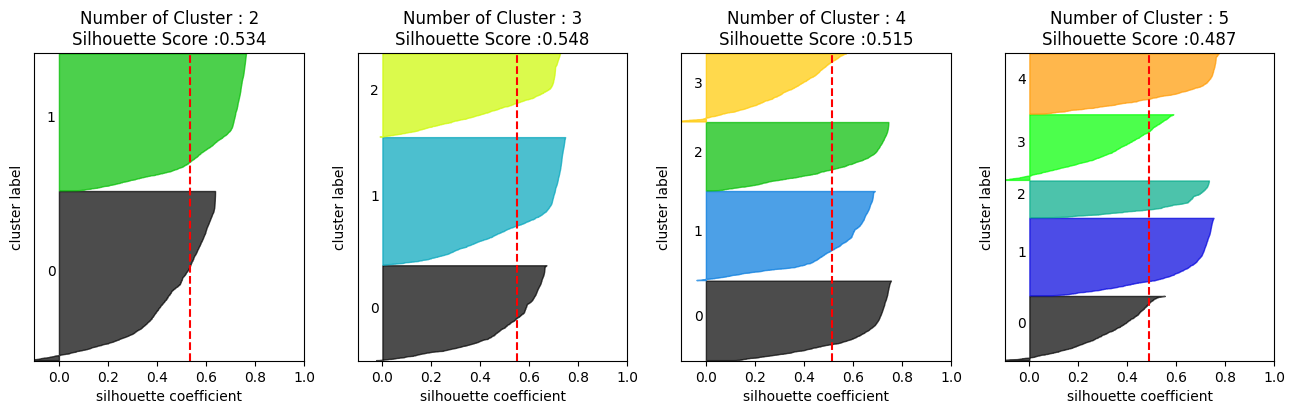

In [144]:
import matplotlib.cm as cm
import math

def my_chart(cluster_lists, X):     
    fig, axs = plt.subplots(figsize=(4*len(cluster_lists), 4), 
                            nrows=1, 
                            ncols=len(cluster_lists))

    for ind, k in enumerate(cluster_lists):
        
        kmeans = KMeans(n_clusters = k, 
                           max_iter=500, random_state=11)
        cluster_labels = kmeans.fit_predict(X)

        sil_coef_mean = silhouette_score(X, cluster_labels)
        sil_coef      = silhouette_samples(X, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(k)+'\n' \
                          'Silhouette Score :' + str(round(sil_coef_mean,3)) )
        axs[ind].set_xlabel("silhouette coefficient")
        axs[ind].set_ylabel("cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X) + (k + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 막대 그래프
        for i in range(k):
            ith_cluster_sil_coef = sil_coef[cluster_labels==i]
            ith_cluster_sil_coef.sort()

            size_cluster_i = ith_cluster_sil_coef.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_coef, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_coef_mean, color="red", linestyle="--")

X = gdf.drop(['Customer ID', 'label'], axis=1)
ss = MinMaxScaler()
X2 = ss.fit_transform(X)

my_chart([2,3,4,5], X2)

### 군집별 통계치

In [151]:
gdf.groupby('label').agg({'Invoicedata_defore':'mean',
                          'Invoicedata_duration':'mean',
                         'OrderCount':'mean',
                         'TotalPrice':'mean'})

,Invoicedata_defore,Invoicedata_duration,OrderCount,TotalPrice
label,,,,
0,483.031653,71.150947,44.131769,41.834103
1,65.621352,551.878516,250.474038,29.900453
2,92.992073,86.712178,63.411119,82.729823


In [153]:
gdf.describe()

,Customer ID,TotalPrice,maxPrice,minPrice,Quantity,maxQuantity,minQuantity,OrderCount,Invoicedata_defore,Invoicedata_duration,label
count,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000
mean,15556.524566,47.984914,30.565668,3.947642,27.716243,122.257613,8.688212,135.493368,202.668814,276.011418,0.961704
std,1581.187812,811.488215,280.439893,154.099284,416.165475,1539.558898,178.619857,325.997871,210.118554,259.722418,0.762434
min,12346.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,14190.000000,10.711622,8.500000,0.210000,5.263158,24.000000,1.000000,20.000000,25.144444,0.000000,0.000000
50%,15564.000000,16.981774,12.750000,0.390000,9.372414,48.000000,1.000000,53.000000,98.090972,227.825694,1.000000
75%,16922.000000,23.656500,16.950000,0.550000,14.048544,72.000000,2.000000,142.000000,381.040278,517.925694,2.000000
max,18287.000000,56157.500000,10953.500000,10953.500000,26999.000000,80995.000000,12540.000000,12890.000000,738.083333,738.101389,2.000000


### R(Recency): 거래의 최근성

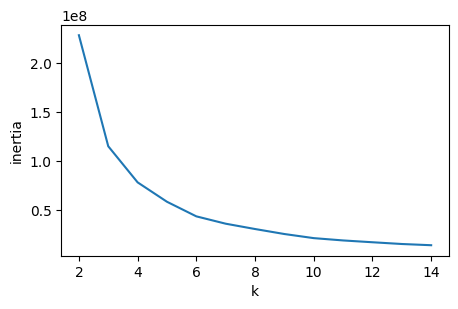

In [111]:
collist = ['Invoicedata_defore','Invoicedata_duration']

scor_list = []
X = gdf[collist]
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=11)
    kmeans.fit(X)   # ---- Predict 할때, y data가 없다.
    inert = kmeans.inertia_
    sil_score = silhouette_score(X, kmeans.labels_)
    scor_list.append([k, inert, sil_score])

tempdf = pd.DataFrame(scor_list, columns=['k', 'inertia', 'sil'])

plt.figure(figsize=(5,3))
sns.lineplot(tempdf, x='k', y='inertia')
plt.show()

78488730.78860724 0.5229575418825475


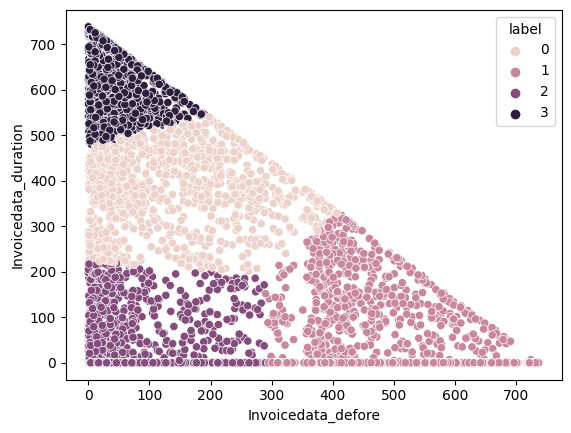

In [112]:
collist = ['Invoicedata_defore','Invoicedata_duration']

X = gdf[collist]
kmeans = KMeans(n_clusters=4, random_state=11)
kmeans.fit(X)  
gdf['label'] = kmeans.labels_

inert = kmeans.inertia_
sil_score = silhouette_score(X, kmeans.labels_)
print(inert, sil_score)

sns.scatterplot(gdf, x='Invoicedata_defore', y='Invoicedata_duration', hue='label')
plt.show()

80.56366764922363 0.5193041229666684


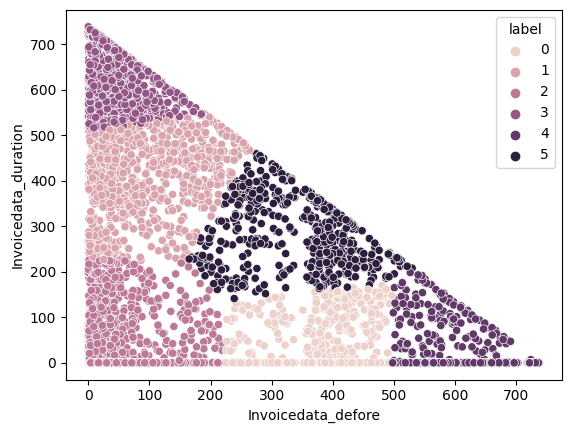

In [113]:
ss = MinMaxScaler()
X = ss.fit_transform(X)

# X = np.log1p(X)

kmeans = KMeans(n_clusters=6, random_state=11)
kmeans.fit(X)  
gdf['label'] = kmeans.labels_

inert = kmeans.inertia_
sil_score = silhouette_score(X, kmeans.labels_)
print(inert, sil_score)

sns.scatterplot(gdf, x='Invoicedata_defore', y='Invoicedata_duration', hue='label')
plt.show()

### F(Frequency): 거래빈도

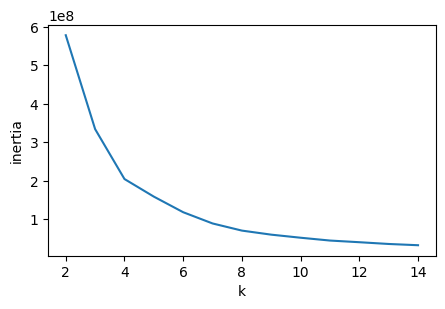

In [114]:
collist = ['OrderCount','Invoicedata_duration']

scor_list = []
X = gdf[collist]
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=11)
    kmeans.fit(X)   # ---- Predict 할때, y data가 없다.
    inert = kmeans.inertia_
    sil_score = silhouette_score(X, kmeans.labels_)
    scor_list.append([k, inert, sil_score])

tempdf = pd.DataFrame(scor_list, columns=['k', 'inertia', 'sil'])

plt.figure(figsize=(5,3))
sns.lineplot(tempdf, x='k', y='inertia')
plt.show()

204355728.37787932 0.6213797794810084


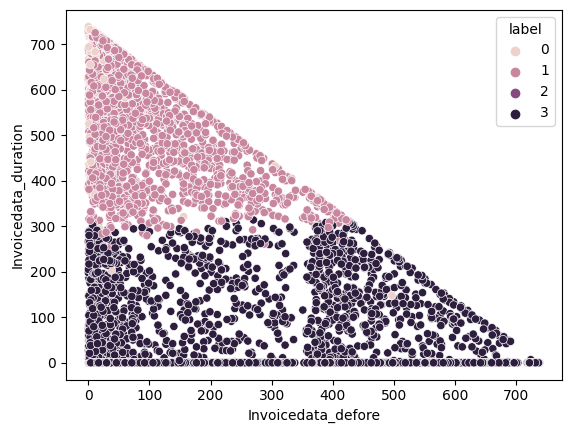

In [115]:
collist = ['OrderCount','Invoicedata_duration']

X = gdf[collist]
kmeans = KMeans(n_clusters=4, random_state=11)
kmeans.fit(X)  
gdf['label'] = kmeans.labels_

inert = kmeans.inertia_
sil_score = silhouette_score(X, kmeans.labels_)
print(inert, sil_score)

sns.scatterplot(gdf, x='Invoicedata_defore', y='Invoicedata_duration', hue='label')
plt.show()

27.830544048769642 0.6734017691931448


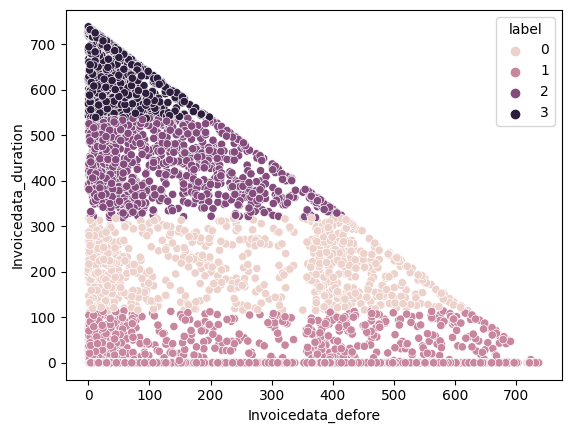

In [116]:
ss = MinMaxScaler()
X = ss.fit_transform(X)

# X = np.log1p(X)

kmeans = KMeans(n_clusters=4, random_state=11)
kmeans.fit(X)  
gdf['label'] = kmeans.labels_

inert = kmeans.inertia_
sil_score = silhouette_score(X, kmeans.labels_)
print(inert, sil_score)

sns.scatterplot(gdf, x='Invoicedata_defore', y='Invoicedata_duration', hue='label')
plt.show()

### M(Monetary): 거래규모

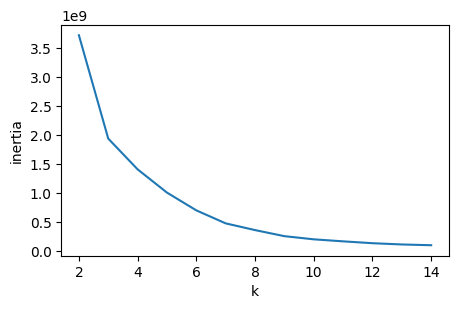

In [118]:
collist = ['TotalPrice', 'maxPrice', 'minPrice', 'Quantity',
       'maxQuantity', 'minQuantity']

scor_list = []
X = gdf[collist]
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=11)
    kmeans.fit(X) 
    inert = kmeans.inertia_
    sil_score = silhouette_score(X, kmeans.labels_)
    scor_list.append([k, inert, sil_score])

tempdf = pd.DataFrame(scor_list, columns=['k', 'inertia', 'sil'])

plt.figure(figsize=(5,3))
sns.lineplot(tempdf, x='k', y='inertia')
plt.show()

357685655.10439867 0.9695744636588597


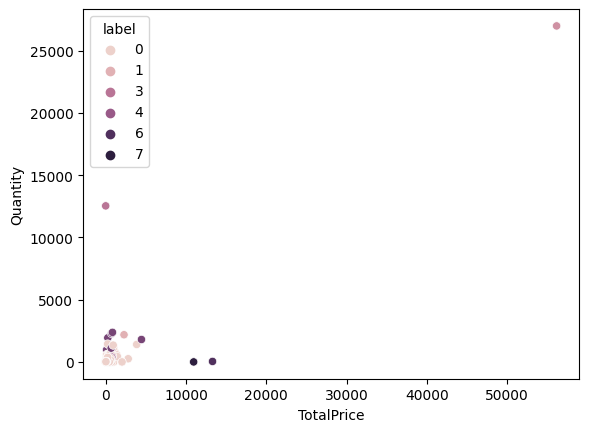

In [120]:
X = gdf[collist]
kmeans = KMeans(n_clusters=8, random_state=11)
kmeans.fit(X)  
gdf['label'] = kmeans.labels_

inert = kmeans.inertia_
sil_score = silhouette_score(X, kmeans.labels_)
print(inert, sil_score)

sns.scatterplot(gdf, x='TotalPrice', y='Quantity', hue='label')
plt.show()

1161.0393407985337 0.9658799558783636


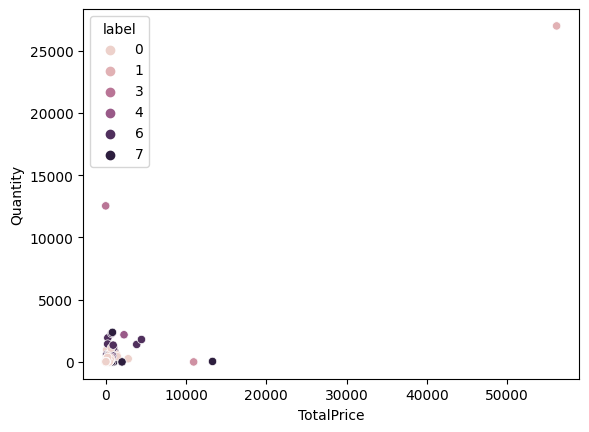

In [121]:
X = gdf[collist]

ss = StandardScaler()
X = ss.fit_transform(X)

kmeans = KMeans(n_clusters=8, random_state=11)
kmeans.fit(X)  
gdf['label'] = kmeans.labels_

inert = kmeans.inertia_
sil_score = silhouette_score(X, kmeans.labels_)
print(inert, sil_score)

sns.scatterplot(gdf, x='TotalPrice', y='Quantity', hue='label')
plt.show()

[0.44018045 0.26123929]


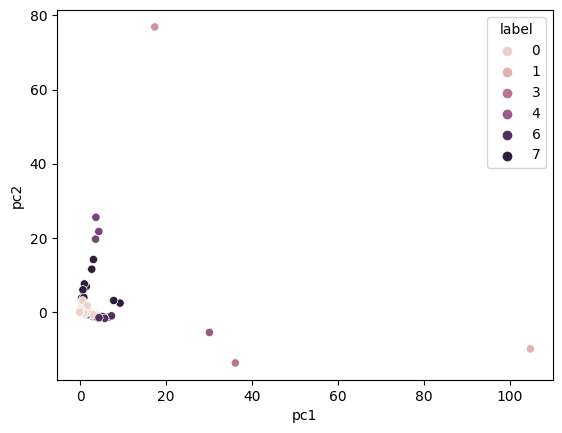

In [122]:
pca = PCA(n_components= 2)

X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

tempdf = pd.DataFrame(X, columns=['pc1','pc2'])
tempdf['label'] = kmeans.labels_

sns.scatterplot(tempdf, x='pc1', y='pc2', hue='label')
plt.show()

## DBSCAN

In [123]:
X = gdf.drop(['Customer ID','label'], axis=1)
ss = StandardScaler()
X = ss.fit_transform(X)

0.79199386109141
[0.2934922  0.20039446]


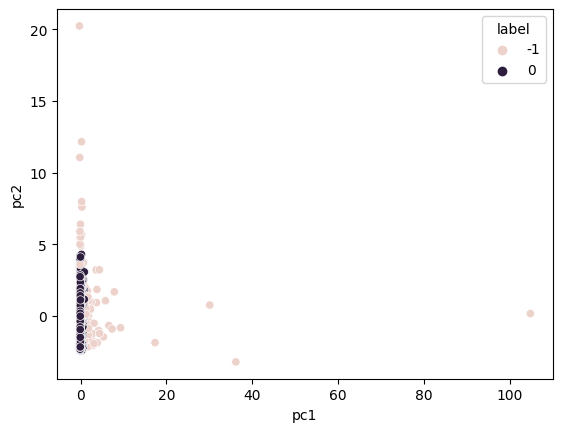

In [124]:
dfsc = DBSCAN(eps=0.7, min_samples=5)
cluster_labels = dfsc.fit_predict(X)
gdf['label'] = cluster_labels

sil_coef_mean = silhouette_score(X, cluster_labels)
print(sil_coef_mean)

pca = PCA(n_components= 2)

X2 = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

tempdf = pd.DataFrame(X2, columns=['pc1','pc2'])
tempdf['label'] = cluster_labels

sns.scatterplot(tempdf, x='pc1', y='pc2', hue='label')
plt.show()

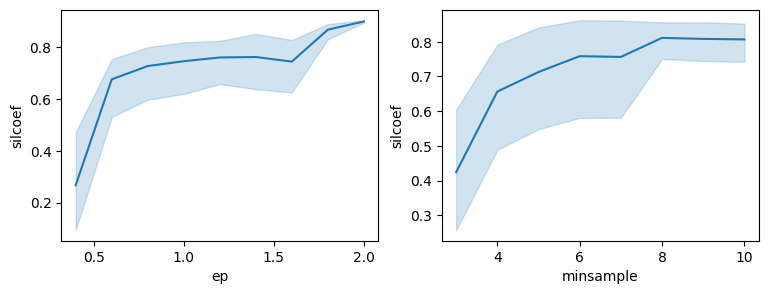

In [126]:
X = gdf.drop(['Customer ID','label'], axis=1)
ss = StandardScaler()
X = ss.fit_transform(X)

eps_list = [0.4, 0.6, 0.8, 1, 1.2]
minsample_list = [3, 4, 5, 6, 7]

result_list = []
inertia_list = []

for ep in eps_list:
    for ms in minsample_list:
        dfsc = DBSCAN(eps=ep, min_samples=ms)
        cluster_labels = dfsc.fit_predict(X)
        sil_coef_mean = silhouette_score(X, cluster_labels)
        result_list.append([ep, ms, sil_coef_mean])

result_df = pd.DataFrame(result_list, columns=['ep', 'minsample','silcoef'])

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.lineplot(result_df, x='ep', y='silcoef', ax=axes[0])
sns.lineplot(result_df, x='minsample', y='silcoef', ax=axes[1])
plt.show()

In [127]:
X = gdf.drop(['Customer ID','label'], axis=1)

ss = StandardScaler()
X = ss.fit_transform(X)

dfsc = DBSCAN(eps=0.7, min_samples=8)
cluster_labels = dfsc.fit_predict(X)

sil_coef_mean = silhouette_score(X, cluster_labels)
sil_coef_mean

0.7856835211588705

## Hierachy Cluster

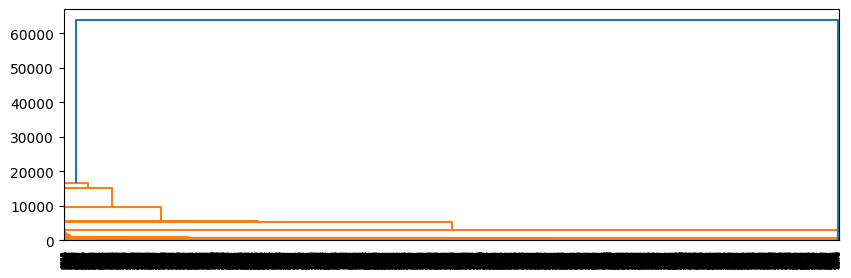

19 0.991568358919216


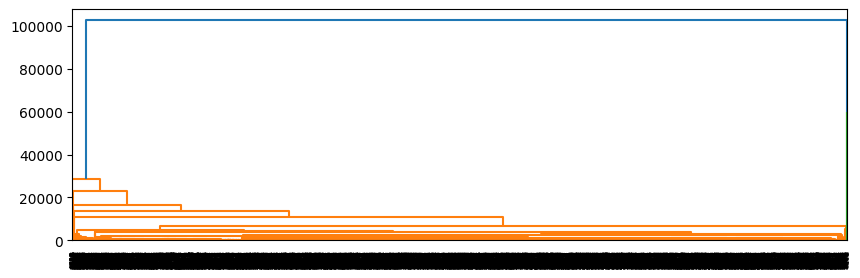

19 0.991568358919216


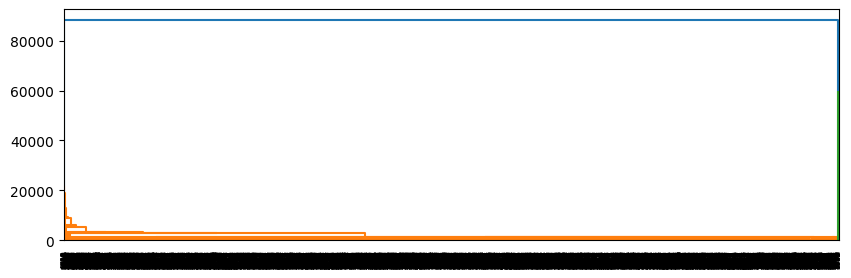

19 0.991568358919216


In [145]:
X = gdf.drop(['Customer ID','label'], axis=1)

method_list = ['single', 'complete', 'average']
res_list = []
for method in method_list:
    dist = linkage(X, method=method)
    
    plt.figure(figsize=(10,3))
    dendrogram(dist)
    plt.show()
    
    max_sil = 0
    max_i = 0
    for i in range(3, 20):
        cluster_label = cut_tree(dist, i).reshape(len(X))
        sil_coef_mean = silhouette_score(X, cluster_label)
        res_list.append([method, i, sil_coef_mean])
        if max_sil < sil_coef_mean:
            max_sil = sil_coef_mean
            max_i = i
    print(i, max_sil)

In [148]:
tempdf = pd.DataFrame(res_list, columns=['method','clu_num','sil'])
tempdf[tempdf['method'] == 'single']

,method,clu_num,sil
0,single,3,0.991568
1,single,4,0.972256
2,single,5,0.968465
3,single,6,0.955859
4,single,7,0.953708
5,single,8,0.938827
6,single,9,0.936406
7,single,10,0.930881
8,single,11,0.921717
9,single,12,0.921487
